Libraries

In [10]:
import cv2,sys,dlib,time,math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import sys
sys.path.append('../resource/lib/public')
import faceBlendCommon as fbc

import matplotlib
matplotlib.rcParams['figure.figsize'] = (10.0,10.0)
matplotlib.rcParams['image.cmap'] = 'gray'
matplotlib.rcParams['image.interpolation'] = 'bilinear'

Landmark detector

In [4]:
# Landmark model location
PREDICTOR_PATH =  "../resource/lib/publicdata/models/shape_predictor_68_face_landmarks.dat"

# Get the face detector
faceDetector = dlib.get_frontal_face_detector()
# The landmark detector is implemented in the shape_predictor class
landmarkDetector = dlib.shape_predictor(PREDICTOR_PATH)

Load Image

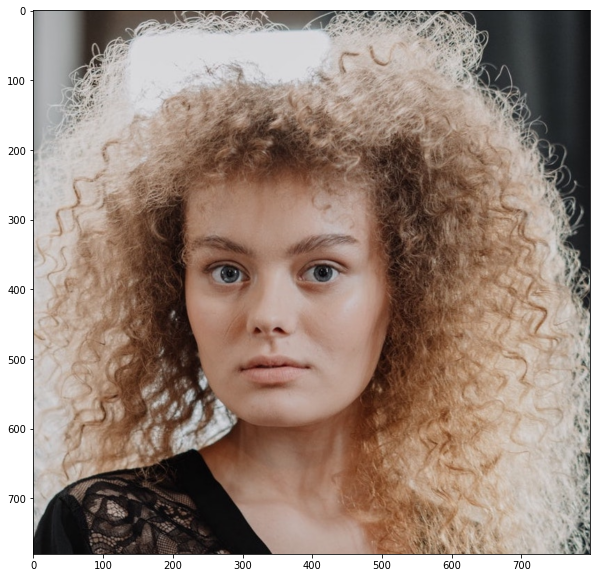

In [11]:
im = cv2.imread("../resource/lib/publicdata/images/girl-no-makeup.jpg")
imDlib = cv2.cvtColor(im,cv2.COLOR_BGR2RGB)
plt.imshow(imDlib)

Extract Land Marks

In [15]:
points = fbc.getLandmarks(faceDetector, landmarkDetector, imDlib)
print(points)

[(216, 375), (217, 411), (224, 446), (233, 480), (242, 515), (258, 547), (283, 574), (313, 594), (350, 600), (390, 595), (430, 579), (464, 557), (488, 524), (501, 487), (508, 447), (513, 408), (514, 369), (223, 343), (241, 326), (268, 325), (293, 333), (317, 346), (362, 345), (389, 331), (418, 321), (449, 321), (474, 336), (338, 374), (337, 397), (335, 419), (333, 442), (315, 465), (326, 468), (337, 471), (351, 468), (364, 465), (252, 378), (268, 368), (289, 369), (307, 385), (287, 390), (266, 389), (382, 384), (401, 369), (423, 367), (441, 375), (426, 387), (404, 389), (293, 517), (310, 503), (327, 496), (340, 500), (353, 496), (376, 502), (401, 514), (377, 528), (356, 535), (341, 536), (326, 535), (310, 530), (303, 516), (327, 512), (340, 512), (354, 511), (391, 513), (354, 512), (341, 513), (327, 513)]


Plot Land Marks

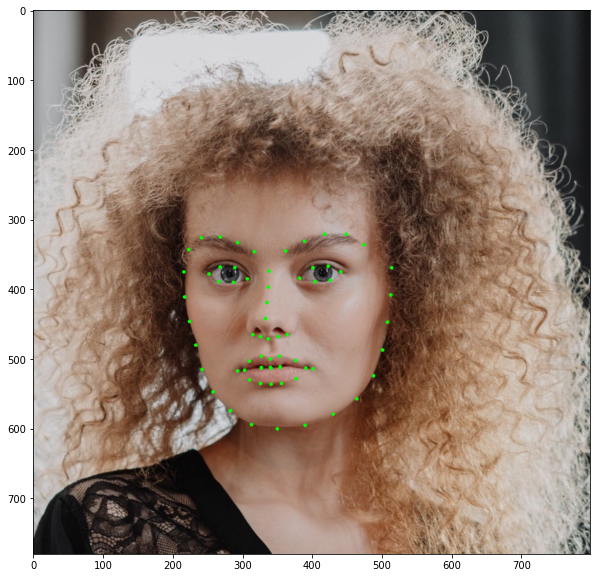

In [16]:
land_mark = imDlib.copy()
for p in points:
    land_mark = cv2.circle(land_mark, p, radius=1, color=(0, 255, 0), thickness=2)
plt.imshow(land_mark)

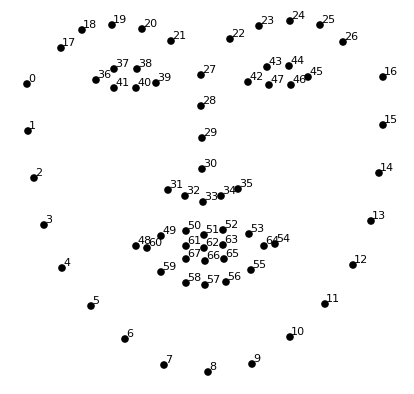

Extract only the polygon of the eyes

In [13]:
def get_bin_mouth():
    dots_mouth = np.array(points[48:], dtype=np.int32)
    bin_mouth = np.zeros(imDlib.shape[:2], dtype=np.uint8)
    bin_mouth = cv2.fillConvexPoly(bin_mouth, dots_mouth, 255)
    
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5,5))
    bin_mouth = cv2.morphologyEx(bin_mouth, cv2.MORPH_CLOSE, kernel)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5,5))
    bin_mouth = cv2.morphologyEx(bin_mouth, cv2.MORPH_OPEN, kernel)
    
    return bin_mouth

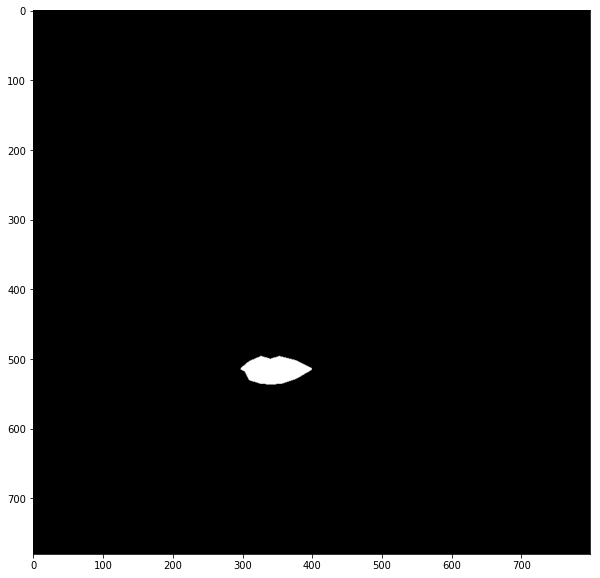

In [17]:
bin_mouth = get_bin_mouth()
plt.imshow(bin_mouth)

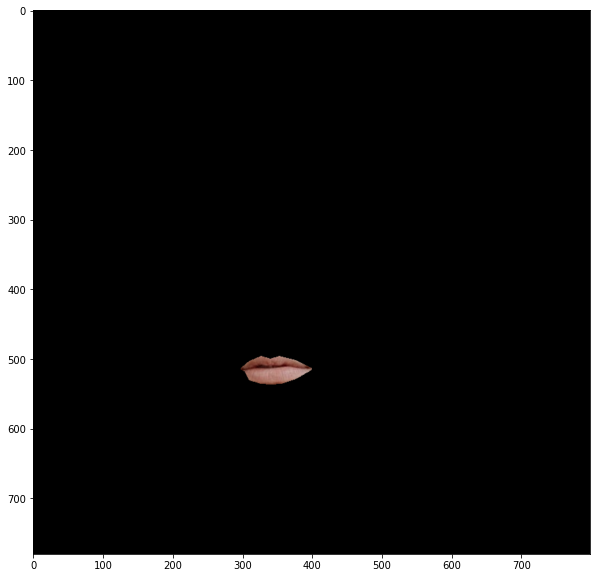

In [19]:
rgb_mouth = cv2.bitwise_and(imDlib, imDlib, mask=bin_mouth)
plt.imshow(rgb_mouth)

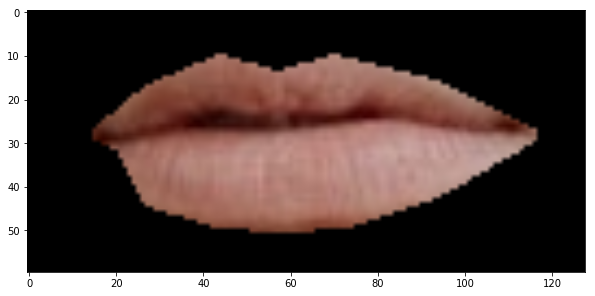

In [29]:
span_y = 10
span_x = 10
x0 = points[48][0]-span_x
x1 = points[54][0]+span_x
y0 = min([x[1] for x in points[50:52+1]])-span_y
y1 = max([x[1] for x in points[56:58+1]])+span_y
plt.imshow(rgb_mouth[y0:y1,x0:x1])

In [20]:
def apply_color_mouth(rgb_mouth,color_name):
    img = np.copy(rgb_mouth)
    originalValue = np.array([0, 50, 100, 150, 200, 255])
    
    if color_name == 'green':
        #green
        bCurve = np.array([0, 20, 50, 70, 220, 255])
        rCurve = np.array([0, 20,  40,  75, 150, 255])
    elif color_name == 'blue':
        #blue
        rCurve = np.array([0, 80, 150, 190, 220, 255])
        bCurve = np.array([0, 20,  40,  75, 150, 255])
    elif color_name == 'orange':
        #orange
        bCurve = np.array([0, 80, 150, 190, 220, 255])
        rCurve = np.array([0, 20,  40,  75, 150, 255])

    fullRange = np.arange(0,256)
    rLUT = np.interp(fullRange, originalValue, rCurve )
    bLUT = np.interp(fullRange, originalValue, bCurve )

    bChannel = img[:,:,0]
    bChannel = cv2.LUT(bChannel, bLUT)
    img[:,:,0] = bChannel

    rChannel = img[:,:,2]
    rChannel = cv2.LUT(rChannel, rLUT)
    img[:,:,2] = rChannel
    
    return img

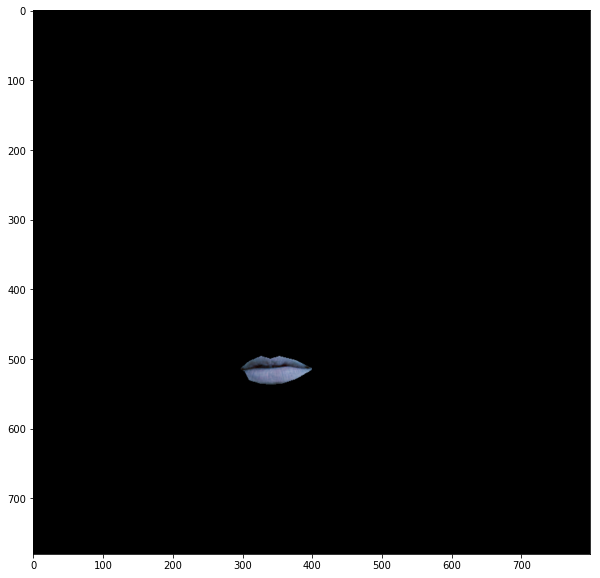

In [23]:
new_mouth = apply_color_mouth(rgb_mouth,'blue')
plt.imshow(new_mouth)

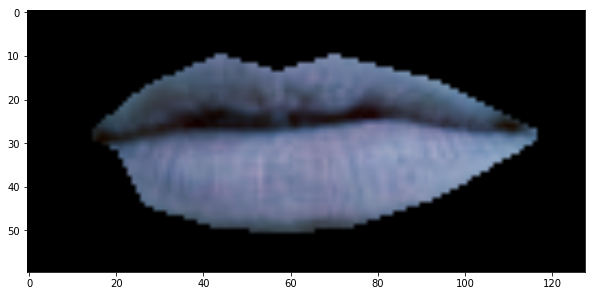

In [30]:
plt.imshow(new_mouth[y0:y1,x0:x1])

In [32]:
back_mouth = cv2.bitwise_and(imDlib, imDlib, mask=(255-bin_mouth))
blue_mouth = back_mouth + new_mouth

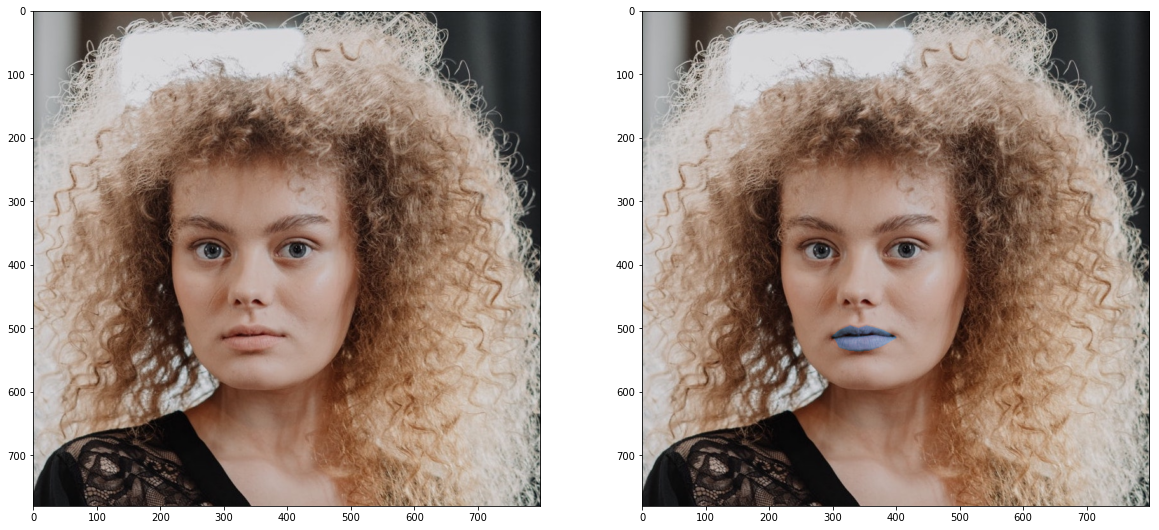

In [33]:
fig=plt.figure(figsize=(20, 20))
fig.add_subplot(1, 2, 1)
plt.imshow(imDlib)
fig.add_subplot(1, 2, 2)
plt.imshow(blue_mouth)
plt.show()